In [ ]:
!pip3 install pyforest
!pip3 install seaborn
!pip3 install plotly
!pip3 install cufflinks
!pip install scorecardpy

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=9e0583faced79db0e055dac66f21dc25272dd5a6a97917e1b57defa5d942906e
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60634 sha256=1e455afce1c4bc86b99245359671b4002c8e82ae9767c57c23d2e2c27e4da2f4
  Stored in directory: /root/.cache/pip/wheels/49/49/e9/7b845548eed3624ce37effdd13e9cb95a99272d692eb9e9e23
Successfully built scorecardpy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
import joblib
from plotly.offline import iplot
import scorecardpy as sc
import copy
from ast import literal_eval
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)

pd.set_option('display.max_columns', None)

In [ ]:
test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

## Discretizar WEALTH_RATING  Y INCOME_GROUP con MISSING, Agrupar variables Cat con bajas frecuencias.

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

def preprocess_data(X):
    # Seleccionar las variables a discretizar
    variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 2, 4, 6, 8, 10]
    labels_wealth_rating = ['Bajo', 'Medio-Bajo', 'Medio', 'Medio-Alto', 'Alto']

    bins_income_group = [0, 2, 4, 6, 8]
    labels_income_group = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']

    bins_age_group = [0, 20, 40, 60, 80, 100]
    labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['WEALTH_RATING_DISCRETIZED'] = np.select(
        [pd.isna(X['WEALTH_RATING']), True],
        ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    X['INCOME_GROUP_DISCRETIZED'] = np.select(
        [pd.isna(X['INCOME_GROUP']), True],
        ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    )

    X['DONOR_AGE_DISCRETIZED'] = np.select(
        [pd.isna(X['DONOR_AGE']), True],
        ['Valor Missing', pd.cut(X['DONOR_AGE'], bins=bins_age_group, labels=labels_age_group, include_lowest=True, right=False, duplicates='drop')]
    )

    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['WEALTH_RATING', 'INCOME_GROUP', 'DONOR_AGE'], axis=1)

    return X

In [ ]:
X.select_dtypes(include=['object']).nunique()

URBANICITY                   6
SES                          5
HOME_OWNER                   2
DONOR_GENDER                 3
OVERLAY_SOURCE               4
RECENCY_STATUS_96NK          5
WEALTH_RATING_DISCRETIZED    6
INCOME_GROUP_DISCRETIZED     5
DONOR_AGE_DISCRETIZED        6
dtype: int64

## XGBoost con LabelCoder (no mejora con oversampling y subsampling). Tolera missing y outliers

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools

test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Label Encoding
for f in X_train.columns:
  if X_train[f].dtype == 'object':
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(X_train[f].values))
    X_train[f] = lbl.transform(list(X_train[f].values))
    X_test[f] = lbl.transform(list(X_test[f].values))

n_estimators_range = [200, 400, 600, 800]
max_depth_range = [2, 3, 5, 7]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.005, 0.01, 0.03]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        scale_pos_weight = np.sum(y_train_fold == 0) / np.sum(y_train_fold == 1)
        # Inicializar y ajustar el modelo
        clf = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=0.66,
            colsample_bytree=0.66,
            random_state=2019,
            tree_method=tree_method,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )
        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]
}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6277
ROC AUC Validation (Mean): 0.6086

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6360
ROC AUC Validation (Mean): 0.6118

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.03}
ROC AUC Train (Mean): 0.6590
ROC AUC Validation (Mean): 0.6167

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6278
ROC AUC Validation (Mean): 0.6085

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6366
ROC AUC Validation (Mean): 0.6126

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learni

KeyboardInterrupt: 

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Inicializar y ajustar el modelo con los mejores hiperparámetros
best_clf = xgb.XGBClassifier(
    n_estimators=best_hyperparameters['n_estimators'],
    max_depth=best_hyperparameters['max_depth'],
    learning_rate=best_hyperparameters['learning_rate'],
    subsample=0.66,
    colsample_bytree=0.66,
    missing=best_hyperparameters['missing_value'],
    random_state=2019,
    tree_method=best_hyperparameters['tree_method'],
    n_jobs=-1,
)

best_clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_test = best_clf.predict_proba(X_test)[:, 1]

# Calcular la curva ROC en el conjunto de prueba
roc_auc_test = roc_auc_score(y_test, y_pred_test)

print(f'ROC AUC Test: {roc_auc_test:.4f}')

# Visualizar la importancia de las variables
plot_importance(clf, importance_type='weight')  # Puedes usar otros tipos como 'gain', 'cover', etc.
plt.show()

## XGBoost con OneHotEncoder

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.preprocessing import OneHotEncoder

test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Identificar columnas categóricas
categorical_columns = X_train.select_dtypes(include='object').columns

# Inicializar el codificador one-hot
onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' para evitar la colinealidad

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Ajustar y transformar el conjunto de entrenamiento
X_train_encoded = pd.DataFrame(onehot_encoder.fit_transform(X_train[categorical_columns]))
X_train_encoded.columns = onehot_encoder.get_feature_names_out(categorical_columns)

# Transformar el conjunto de prueba
X_test_encoded = pd.DataFrame(onehot_encoder.transform(X_test[categorical_columns]))
X_test_encoded.columns = onehot_encoder.get_feature_names_out(categorical_columns)

# Concatenar las columnas codificadas con las no categóricas
X_train = pd.concat([X_train.drop(categorical_columns, axis=1), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(categorical_columns, axis=1), X_test_encoded], axis=1)

print("Duplicated indices in X_train:", X_train.index.duplicated().sum())
print("Duplicated indices in y_train:", y_train.index.duplicated().sum())

n_estimators_range = [200, 400]
max_depth_range = [2, 3, 5, 7]
tree_method_range = ['exact', 'hist']
learning_rate_range = [0.005, 0.01, 0.03]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}

Duplicated indices in X_train: 0
Duplicated indices in y_train: 0

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6279
ROC AUC Validation (Mean): 0.6084

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6361
ROC AUC Validation (Mean): 0.6115

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.03}
ROC AUC Train (Mean): 0.6596
ROC AUC Validation (Mean): 0.6161

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'hist', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6278
ROC AUC Validation (Mean): 0.6088

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'hist', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6363
ROC AUC Validation (Mean): 0.6118

Evaluando con hiperparámetros: {'

## XGBoost con transformaciones previas datos

In [ ]:
from sklearn.cluster import KMeans

def fit_reduce_clases(var, df, y, n=5):
  x = []
  for clase in df[var].values:
    if pd.isna(clase):
      x.append(-1)
    else:
      x.append(clase)

  # Calcula la media de la variable de interés para cada clase
  medias_por_clase = {}
  for clase in np.unique(x):
      medias_por_clase[clase] = np.mean(y[x == clase])

  # Convierte las medias a una matriz para usar en KMeans
  X = np.array(list(medias_por_clase.values())).reshape(-1, 1)

  # Número de clústeres deseado
  num_clusters = 5

  # Aplica el algoritmo K-means
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X)

  # Obtén las etiquetas de los clústeres para cada clase
  etiquetas = kmeans.labels_

  # Agrupa las clases según las etiquetas de los clústeres
  clases_agrupadas = {}
  for clase, etiqueta in zip(medias_por_clase.keys(), etiquetas):
    clases_agrupadas[clase] = etiqueta

  return clases_agrupadas

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600]
max_depth_range = [3, 5, 7]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.01, 0.03]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}



Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6641
ROC AUC Validation (Mean): 0.6164

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.03}
ROC AUC Train (Mean): 0.7017
ROC AUC Validation (Mean): 0.6154

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6629
ROC AUC Validation (Mean): 0.6162

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'exact', 'learning_rate': 0.03}
ROC AUC Train (Mean): 0.7010
ROC AUC Validation (Mean): 0.6156

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6632
ROC AUC Validation (Mean): 0.6160

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learn

## Añadiendo scale_pos_weight (parece que mejore algo):


In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600]
max_depth_range = [3, 5, 7]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.01, 0.03]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6667
ROC AUC Validation (Mean): 0.6178

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.03}
ROC AUC Train (Mean): 0.7065
ROC AUC Validation (Mean): 0.6182

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6679
ROC AUC Validation (Mean): 0.6192

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'exact', 'learning_rate': 0.03}
ROC AUC Train (Mean): 0.7086
ROC AUC Validation (Mean): 0.6214

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6687
ROC AUC Validation (Mean): 0.6193

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learn

In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200]
max_depth_range = [3]
tree_method_range = ['approx']
learning_rate_range = [0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.6984
ROC AUC Validation (Mean): 0.6209


## Modificando las transformaciones:

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

def preprocess_data2(X):
    # Seleccionar las variables a discretizar
    variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 1, 2, 3, 4, 5,6,7,8,9,10]
    labels_wealth_rating = ['1', '2', '3', '4', '5', '6','7','8','9','10']

    bins_income_group = [0,1, 2, 3,4,5, 6,7, 8]
    labels_income_group = ['1', '2', '3', '4','5','6','7','8']

    bins_status_rating = [1, 2, 3,4,5]
    labels_status_rating = ['1', '2', '3', '4']

    #bins_age_group = [0, 20, 40, 60, 80, 100]
    #labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['WEALTH_RATING_DISCRETIZED'] = np.select(
        [pd.isna(X['WEALTH_RATING']), True],
        ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['FREQUENCY_STATUS_97NK_DISCRETIZED'] = np.select(
        [pd.isna(X['FREQUENCY_STATUS_97NK']), True],
        ['Valor Missing', pd.cut(X['FREQUENCY_STATUS_97NK'], bins=bins_status_rating, labels=labels_status_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    X['INCOME_GROUP_DISCRETIZED'] = np.select(
        [pd.isna(X['INCOME_GROUP']), True],
        ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    )


    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['WEALTH_RATING', 'INCOME_GROUP','FREQUENCY_STATUS_97NK'], axis=1)

    return X

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

def preprocess_data2_mod(X):
    # Seleccionar las variables a discretizar
    variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 1, 2, 3, 4, 5,6,7,8,9,10]
    labels_wealth_rating = ['1', '2', '3', '4', '5', '6','7','8','9','10']

    bins_income_group = [0,1, 2, 3,4,5, 6,7, 8]
    labels_income_group = ['1', '2', '3', '4','5','6','7','8']

    bins_age_group = [0,10, 20, 30,40,50, 60,70, 80,90]
    labels_age_group = ['1', '2', '3', '4','5','6','7','8','9']

    bins_status_rating = [1, 2, 3,4,5]
    labels_status_rating = ['1', '2', '3', '4']

    #bins_age_group = [0, 20, 40, 60, 80, 100]
    #labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['WEALTH_RATING_DISCRETIZED'] = np.select(
        [pd.isna(X['WEALTH_RATING']), True],
        ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['FREQUENCY_STATUS_97NK_DISCRETIZED'] = np.select(
        [pd.isna(X['FREQUENCY_STATUS_97NK']), True],
        ['Valor Missing', pd.cut(X['FREQUENCY_STATUS_97NK'], bins=bins_status_rating, labels=labels_status_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    X['INCOME_GROUP_DISCRETIZED'] = np.select(
        [pd.isna(X['INCOME_GROUP']), True],
        ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    )

    X['DONOR_AGE_DISCRETIZED'] = np.select(
        [pd.isna(X['DONOR_AGE']), True],
        ['Valor Missing', pd.cut(X['DONOR_AGE'], bins=bins_age_group, labels=labels_age_group, include_lowest=True, right=False, duplicates='drop')]
    )


    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['WEALTH_RATING', 'INCOME_GROUP','FREQUENCY_STATUS_97NK','DONOR_AGE'], axis=1)

    return X

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

def preprocess_data2_mod2(X):
    # Seleccionar las variables a discretizar
    variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 1, 2, 3, 4, 5,6,7,8,9,10]
    labels_wealth_rating = ['1', '2', '3', '4', '5', '6','7','8','9','10']

    bins_income_group = [0,1, 2, 3,4,5, 6,7, 8]
    labels_income_group = ['1', '2', '3', '4','5','6','7','8']

    bins_age_group = [0,10, 20, 30,40,50, 60,70, 80,90]
    labels_age_group = ['1', '2', '3', '4','5','6','7','8','9']

    bins_status_rating = [1, 2, 3,4,5]
    labels_status_rating = ['1', '2', '3', '4']

    #bins_age_group = [0, 20, 40, 60, 80, 100]
    #labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['WEALTH_RATING_DISCRETIZED'] = np.select(
        [pd.isna(X['WEALTH_RATING']), True],
        ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['FREQUENCY_STATUS_97NK_DISCRETIZED'] = np.select(
        [pd.isna(X['FREQUENCY_STATUS_97NK']), True],
        ['Valor Missing', pd.cut(X['FREQUENCY_STATUS_97NK'], bins=bins_status_rating, labels=labels_status_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    #X['INCOME_GROUP_DISCRETIZED'] = np.select(
    #    [pd.isna(X['INCOME_GROUP']), True],
    #    ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    #)

    #X['DONOR_AGE_DISCRETIZED'] = np.select(
    #    [pd.isna(X['DONOR_AGE']), True],
    #    ['Valor Missing', pd.cut(X['DONOR_AGE'], bins=bins_age_group, labels=labels_age_group, include_lowest=True, right=False, duplicates='drop')]
    #)


    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['WEALTH_RATING','FREQUENCY_STATUS_97NK'], axis=1)

    return X

In [ ]:
def preprocess_data2_mod3(X):
    # Seleccionar las variables a discretizar
    #variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 1, 2, 3, 4, 5,6,7,8,9,10]
    labels_wealth_rating = ['1', '2', '3', '4', '5', '6','7','8','9','10']

    bins_income_group = [0,1, 2, 3,4,5, 6,7, 8]
    labels_income_group = ['1', '2', '3', '4','5','6','7','8']

    bins_age_group = [0,10, 20, 30,40,50, 60,70, 80,90]
    labels_age_group = ['1', '2', '3', '4','5','6','7','8','9']

    bins_status_rating = [1, 2, 3,4,5]
    labels_status_rating = ['1', '2', '3', '4']

    #bins_age_group = [0, 20, 40, 60, 80, 100]
    #labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    #X['WEALTH_RATING_DISCRETIZED'] = np.select(
    #    [pd.isna(X['WEALTH_RATING']), True],
    #    ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    #)

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['FREQUENCY_STATUS_97NK_DISCRETIZED'] = np.select(
        [pd.isna(X['FREQUENCY_STATUS_97NK']), True],
        ['Valor Missing', pd.cut(X['FREQUENCY_STATUS_97NK'], bins=bins_status_rating, labels=labels_status_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    #X['INCOME_GROUP_DISCRETIZED'] = np.select(
    #    [pd.isna(X['INCOME_GROUP']), True],
    #    ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    #)

    #X['DONOR_AGE_DISCRETIZED'] = np.select(
    #    [pd.isna(X['DONOR_AGE']), True],
    #    ['Valor Missing', pd.cut(X['DONOR_AGE'], bins=bins_age_group, labels=labels_age_group, include_lowest=True, right=False, duplicates='drop')]
    #)


    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['FREQUENCY_STATUS_97NK'], axis=1)

    return X

In [ ]:
def preprocess_data2_mod4(X):
    # Seleccionar las variables a discretizar
    #variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 1, 2, 3, 4, 5,6,7,8,9,10]
    labels_wealth_rating = ['1', '2', '3', '4', '5', '6','7','8','9','10']

    bins_income_group = [0,1, 2, 3,4,5, 6,7, 8]
    labels_income_group = ['1', '2', '3', '4','5','6','7','8']

    bins_age_group = [0,10, 20, 30,40,50, 60,70, 80,90]
    labels_age_group = ['1', '2', '3', '4','5','6','7','8','9']

    bins_status_rating = [1, 2, 3,4,5]
    labels_status_rating = ['1', '2', '3', '4']

    #bins_age_group = [0, 20, 40, 60, 80, 100]
    #labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['WEALTH_RATING_DISCRETIZED'] = np.select(
        [pd.isna(X['WEALTH_RATING']), True],
        ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    #X['FREQUENCY_STATUS_97NK_DISCRETIZED'] = np.select(
    #    [pd.isna(X['FREQUENCY_STATUS_97NK']), True],
    #    ['Valor Missing', pd.cut(X['FREQUENCY_STATUS_97NK'], bins=bins_status_rating, labels=labels_status_rating, include_lowest=True, right=False, duplicates='drop')]
    #)

    #X['INCOME_GROUP_DISCRETIZED'] = np.select(
    #    [pd.isna(X['INCOME_GROUP']), True],
    #    ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    #)

    #X['DONOR_AGE_DISCRETIZED'] = np.select(
    #    [pd.isna(X['DONOR_AGE']), True],
    #    ['Valor Missing', pd.cut(X['DONOR_AGE'], bins=bins_age_group, labels=labels_age_group, include_lowest=True, right=False, duplicates='drop')]
    #)


    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['WEALTH_RATING'], axis=1)

    return X

In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)



# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)


# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

n_estimators_range = [200, 400, 600,800]
max_depth_range = [2,3,4,5]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6343
ROC AUC Validation (Mean): 0.6157

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6432
ROC AUC Validation (Mean): 0.6172

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.6625
ROC AUC Validation (Mean): 0.6195

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6360
ROC AUC Validation (Mean): 0.6144

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6435
ROC AUC Validation (Mean): 0.6163

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learn

KeyboardInterrupt: 

### Prueba sin imputer:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600,800]
max_depth_range = [2,3,4,5]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)


        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6345
ROC AUC Validation (Mean): 0.6145

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6442
ROC AUC Validation (Mean): 0.6186

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.6623
ROC AUC Validation (Mean): 0.6222

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6356
ROC AUC Validation (Mean): 0.6142

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6435
ROC AUC Validation (Mean): 0.6168

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learn

ROC AUC Train : 0.7382
ROC AUC Test: 0.6396


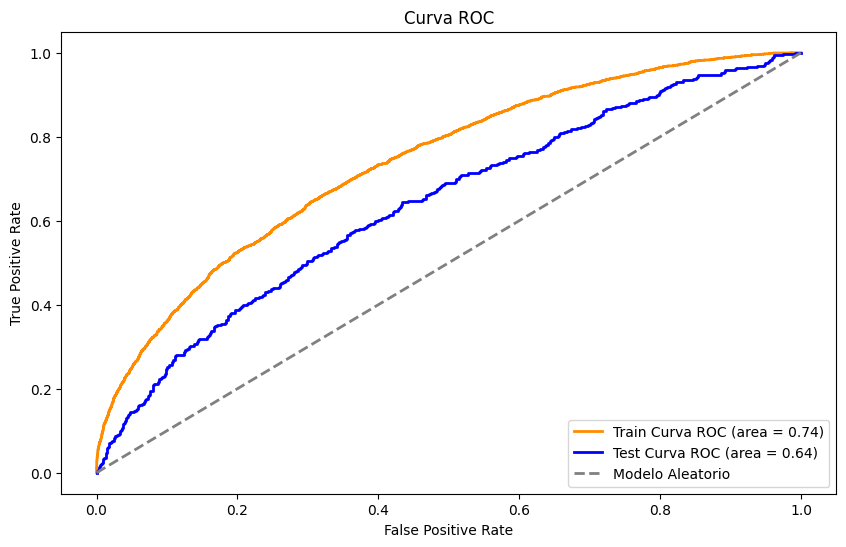

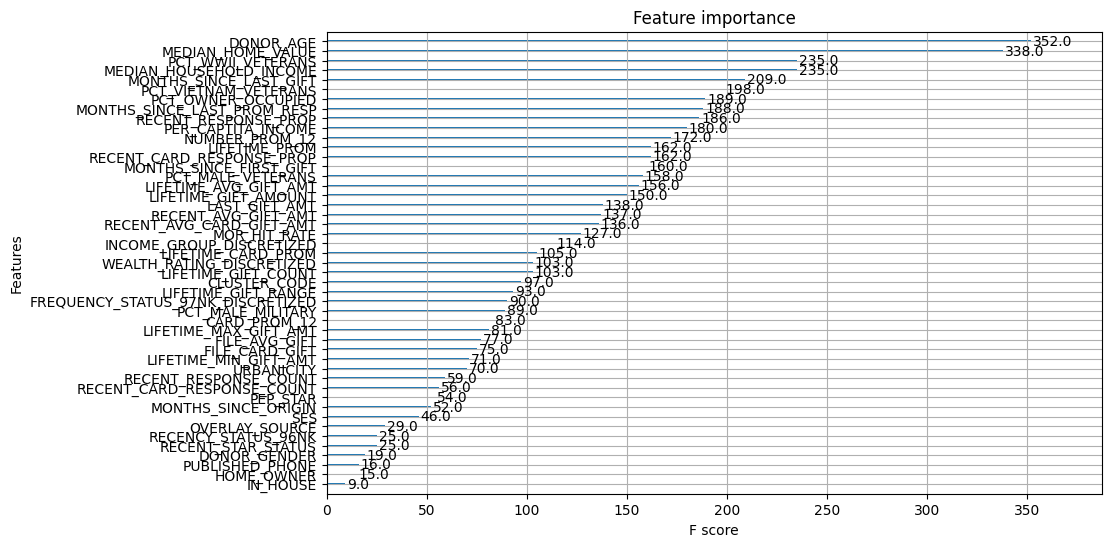

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')

X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method='auto',
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
        )

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

# Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
X_train['Response_Variable'] = y_train.values
X_test['Response_Variable'] = y_test.values

# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)
X_test = X_test.drop('Response_Variable', axis=1)


# Ajustar el modelo
best_clf.fit(X_train, y_train)

# Realizar predicciones en conjuntos de entrenamiento y validación
y_pred_train = best_clf.predict_proba(X_train)[:, 1]
y_pred_test = best_clf.predict_proba(X_test)[:, 1]

# Calcular y almacenar las métricas de rendimiento por pliegue
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

#Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
print(f'ROC AUC Train : {roc_auc_train:.4f}')
print(f'ROC AUC Test: {roc_auc_test:.4f}')

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc

# Calcular y visualizar las curvas ROC en conjuntos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train Curva ROC (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test Curva ROC (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Modelo Aleatorio')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

from xgboost import plot_importance
import matplotlib.pyplot as plt

# Visualizar la importancia de las variables
plot_importance(best_clf, importance_type='weight')  # Puedes usar otros tipos como 'gain', 'cover', etc.
plt.show()

## Cambiando el porcentaje de caracteristicas:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600,800]
max_depth_range = [2,3,4,5]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.8,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)


        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6354
ROC AUC Validation (Mean): 0.6142

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6449
ROC AUC Validation (Mean): 0.6181

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.6633
ROC AUC Validation (Mean): 0.6222

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6340
ROC AUC Validation (Mean): 0.6148

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6433
ROC AUC Validation (Mean): 0.6168

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learn

KeyboardInterrupt: 

### Prueba sin Imputer y Preprocess2_mod:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2_mod(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600,800]
max_depth_range = [2,3,4,5]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)


        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6341
ROC AUC Validation (Mean): 0.6148

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6425
ROC AUC Validation (Mean): 0.6161

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.6619
ROC AUC Validation (Mean): 0.6202

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6340
ROC AUC Validation (Mean): 0.6136

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6436
ROC AUC Validation (Mean): 0.6175

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learn

###Preprocess 2 Mod 2:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2_mod2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600]
max_depth_range = [3,4,5]
tree_method_range = ['auto', 'exact', 'approx', 'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)


        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6576
ROC AUC Validation (Mean): 0.6202

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6697
ROC AUC Validation (Mean): 0.6196

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.7017
ROC AUC Validation (Mean): 0.6223

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6567
ROC AUC Validation (Mean): 0.6184

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6699
ROC AUC Validation (Mean): 0.6209

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'exact', 'learn

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2_mod3(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600]
max_depth_range = [3,4,5]
tree_method_range = ['auto', 'approx', 'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)


        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6551
ROC AUC Validation (Mean): 0.6183

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6701
ROC AUC Validation (Mean): 0.6208

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.7001
ROC AUC Validation (Mean): 0.6223

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6570
ROC AUC Validation (Mean): 0.6199

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6702
ROC AUC Validation (Mean): 0.6203

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'le

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2_mod4(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600]
max_depth_range = [3,4,5]
tree_method_range = ['auto', 'approx', 'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)


        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6557
ROC AUC Validation (Mean): 0.6176

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6697
ROC AUC Validation (Mean): 0.6202

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.7001
ROC AUC Validation (Mean): 0.6196

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6556
ROC AUC Validation (Mean): 0.6184

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6692
ROC AUC Validation (Mean): 0.6192

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 3, 'tree_method': 'approx', 'le

## Sin KNN y FREQUENCY STATUS como numérica

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

def preprocess_data3(X):
    # Seleccionar las variables a discretizar
    variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 1, 2, 3, 4, 5,6,7,8,9,10]
    labels_wealth_rating = ['1', '2', '3', '4', '5', '6','7','8','9','10']

    bins_income_group = [0,1, 2, 3,4,5, 6,7, 8]
    labels_income_group = ['1', '2', '3', '4','5','6','7','8']

    #bins_status_rating = [1, 2, 3,4,5]
    #labels_status_rating = ['1', '2', '3', '4']

    #bins_age_group = [0, 20, 40, 60, 80, 100]
    #labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['WEALTH_RATING_DISCRETIZED'] = np.select(
        [pd.isna(X['WEALTH_RATING']), True],
        ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    #X['FREQUENCY_STATUS_97NK_DISCRETIZED'] = np.select(
    #    [pd.isna(X['FREQUENCY_STATUS_97NK']), True],
    #    ['Valor Missing', pd.cut(X['FREQUENCY_STATUS_97NK'], bins=bins_status_rating, labels=labels_status_rating, include_lowest=True, right=False, duplicates='drop')]
    #)

    X['INCOME_GROUP_DISCRETIZED'] = np.select(
        [pd.isna(X['INCOME_GROUP']), True],
        ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    )


    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['WEALTH_RATING', 'INCOME_GROUP'], axis=1)

    return X

In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data3(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600,800]
max_depth_range = [2,3,4,5]
tree_method_range = ['auto' ,'exact','approx','hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)


        # Ajustar el modelo
        clf.fit(X_train_fold, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6335
ROC AUC Validation (Mean): 0.6141

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6432
ROC AUC Validation (Mean): 0.6171

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.6623
ROC AUC Validation (Mean): 0.6224

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6342
ROC AUC Validation (Mean): 0.6154

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6445
ROC AUC Validation (Mean): 0.6171

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'exact', 'learn

KeyboardInterrupt: 

## Con KNN y FREQUENCY STATUS como numérica

In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data3(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=42, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [200, 400, 600]
max_depth_range = [2,3,4,5]
tree_method_range = ['auto' ,'hist']
learning_rate_range = [0.005,0.01, 0.025]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

# Iterar sobre combinaciones de hiperparámetros
for (n_estimators, max_depth, tree_method, learning_rate) in itertools.product(n_estimators_range, max_depth_range, tree_method_range, learning_rate_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'tree_method': tree_method, 'learning_rate': learning_rate}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method=tree_method,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(tree_method_range) * len(learning_rate_range) )) // (len(tree_method_range) * len(learning_rate_range))],
                        'tree_method': tree_method_range[(best_idx % (len(tree_method_range) * len(learning_rate_range))) // (len(learning_rate_range) )],
                        'learning_rate': learning_rate_range[(best_idx % (len(learning_rate_range)))]}


Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6342
ROC AUC Validation (Mean): 0.6148

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6428
ROC AUC Validation (Mean): 0.6163

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'auto', 'learning_rate': 0.025}
ROC AUC Train (Mean): 0.6615
ROC AUC Validation (Mean): 0.6204

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'hist', 'learning_rate': 0.005}
ROC AUC Train (Mean): 0.6342
ROC AUC Validation (Mean): 0.6137

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'hist', 'learning_rate': 0.01}
ROC AUC Train (Mean): 0.6424
ROC AUC Validation (Mean): 0.6169

Evaluando con hiperparámetros: {'n_estimators': 200, 'max_depth': 2, 'tree_method': 'hist', 'learning

## Random Forest:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [50, 100, 200, 400]
min_samples_split_range = [2, 5, 10, 20]
ccp_alpha_range = [0, 0.01, 0.001]
min_impurity_decrease_range = [0.0, 0.01, 0.001]
max_depth_range = [None, 5, 10, 20]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (n_estimators,max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(n_estimators_range, max_depth_range,min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth':max_depth,'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Random Forest
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        max_depth = max_depth,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced',
        random_state=2019,
        n_jobs=-1,
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}



Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5922

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5924
ROC AUC Validation (Mean): 0.5895

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.6479
ROC AUC Validation (Mean): 0.6096

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5924
ROC AUC Validation (Mean): 0.5895

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5924

IndexError: list index out of range

In [ ]:
# Supongamos que 'best_clf' es tu modelo entrenado con los mejores hiperparámetros
feature_importances = best_clf.feature_importances_

# Crear un DataFrame para visualizar las importancias de las características
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia en orden descendente
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Imprimir o visualizar las importancias de las características
print(importances_df)

##Usando Preprocess 2:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [50, 100, 200, 400]
min_samples_split_range = [2, 5, 10, 20]
ccp_alpha_range = [0, 0.01, 0.001]
min_impurity_decrease_range = [0.0, 0.01, 0.001]
max_depth_range = [None, 5, 10, 20]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (n_estimators,max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(n_estimators_range, max_depth_range,min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth':max_depth,'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Random Forest
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        max_depth = max_depth,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced',
        random_state=2019,
        n_jobs=-1,
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}


Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5854

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5789
ROC AUC Validation (Mean): 0.5748

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.6504
ROC AUC Validation (Mean): 0.6105

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5789
ROC AUC Validation (Mean): 0.5748

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5789

ROC AUC Train : 0.6506
ROC AUC Test: 0.6277
                               Feature  Importance
37                       LAST_GIFT_AMT    0.069421
45   FREQUENCY_STATUS_97NK_DISCRETIZED    0.068387
24           RECENT_CARD_RESPONSE_PROP    0.057739
22                RECENT_RESPONSE_PROP    0.052358
42                       FILE_AVG_GIFT    0.048087
26               RECENT_RESPONSE_COUNT    0.043798
11                   MEDIAN_HOME_VALUE    0.043477
33               LIFETIME_AVG_GIFT_AMT    0.041591
25            RECENT_AVG_CARD_GIFT_AMT    0.040073
23                 RECENT_AVG_GIFT_AMT    0.037717
19                            PEP_STAR    0.036856
40              MONTHS_SINCE_LAST_GIFT    0.033442
12             MEDIAN_HOUSEHOLD_INCOME    0.033357
14                  PER_CAPTITA_INCOME    0.032811
35               LIFETIME_MAX_GIFT_AMT    0.032532
27          RECENT_CARD_RESPONSE_COUNT    0.031595
43                      FILE_CARD_GIFT    0.027802
32                 LIFETIME_GIFT_COUNT

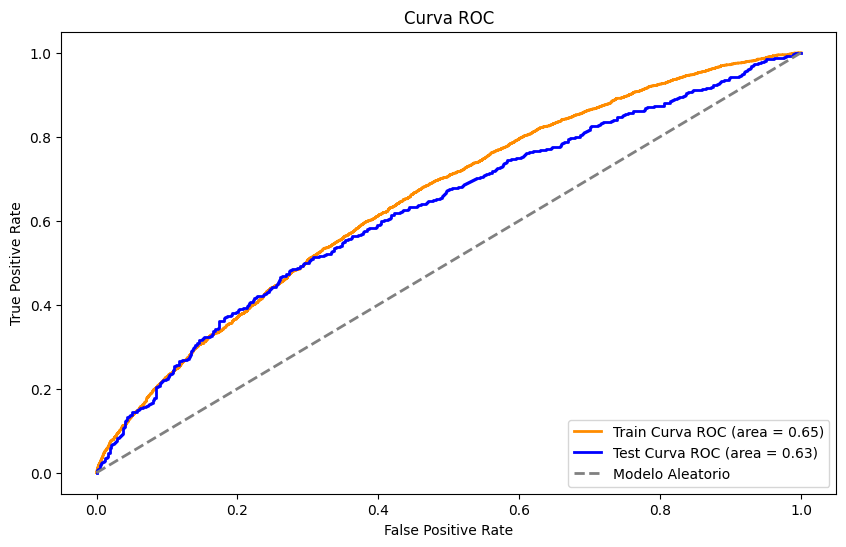

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf = RandomForestClassifier(
        n_estimators=50,
        min_samples_split=2,
        ccp_alpha=0.001,
        max_depth = 20,
        min_impurity_decrease=0,
        class_weight='balanced',
        random_state=2019,
        n_jobs=-1
)

X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

# Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
X_train['Response_Variable'] = y_train.values
X_test['Response_Variable'] = y_test.values

# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)
X_test = X_test.drop('Response_Variable', axis=1)

# Imputar los valores missing en X_train_fold usando k-NN
X_train_imputed = imputer.fit_transform(X_train)

# Aplicar la imputación al conjunto de validación (X_val_fold)
X_test_imputed = imputer.transform(X_test)

# Ajustar el modelo
best_clf.fit(X_train_imputed, y_train)

# Realizar predicciones en conjuntos de entrenamiento y validación
y_pred_train = best_clf.predict_proba(X_train_imputed)[:, 1]
y_pred_test = best_clf.predict_proba(X_test_imputed)[:, 1]

# Calcular y almacenar las métricas de rendimiento por pliegue
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

#Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
print(f'ROC AUC Train : {roc_auc_train:.4f}')
print(f'ROC AUC Test: {roc_auc_test:.4f}')

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc

# Supongamos que 'best_clf' es tu modelo entrenado con los mejores hiperparámetros
feature_importances = best_clf.feature_importances_

# Crear un DataFrame para visualizar las importancias de las características
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia en orden descendente
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Imprimir o visualizar las importancias de las características
print(importances_df)

# Calcular y visualizar las curvas ROC en conjuntos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train Curva ROC (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test Curva ROC (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Modelo Aleatorio')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Usando PreprocessData3:

In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data3(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

n_estimators_range = [50, 100, 200, 400]
min_samples_split_range = [2, 5, 10, 20]
ccp_alpha_range = [0, 0.01, 0.001]
min_impurity_decrease_range = [0.0, 0.01, 0.001]
max_depth_range = [None, 5, 10, 20]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (n_estimators,max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(n_estimators_range, max_depth_range,min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'n_estimators': n_estimators, 'max_depth':max_depth,'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Random Forest
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        max_depth = max_depth,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced',
        random_state=2019,
        n_jobs=-1,
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'n_estimators': n_estimators_range[best_idx // (len(max_depth_range) * len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'max_depth': max_depth_range[(best_idx % (len(max_depth_range) * len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}


Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5836

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5900
ROC AUC Validation (Mean): 0.5857

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.6506
ROC AUC Validation (Mean): 0.6096

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5900
ROC AUC Validation (Mean): 0.5857

Evaluando con hiperparámetros: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5900

## Decision Trees

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

# Definir rangos de hiperparámetros
max_depth_range = [None, 5, 10, 20, 25]
min_samples_split_range = [2, 5, 10, 25, 50]
ccp_alpha_range = [0, 0.01, 0.001,0.0001]
min_impurity_decrease_range = [0.0, 0.01, 0.001,0.0001]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(max_depth_range, min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Decision Tree
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced'
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'max_depth': max_depth_range[best_idx // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}



Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5168

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.6196
ROC AUC Validation (Mean): 0.5924

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0001}
ROC AUC Train (Mean): 0.9981
ROC AUC Validation (Mean): 0.5122

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_s

IndexError: list index out of range

In [ ]:
# Mejores hiperparámetros seleccionados
best_max_depth = best_hyperparameters['max_depth']
best_min_samples_split = best_hyperparameters['min_samples_split']
best_ccp_alpha = best_hyperparameters['ccp_alpha']
best_min_impurity_decrease = best_hyperparameters['min_impurity_decrease']

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    ccp_alpha=best_ccp_alpha,
    min_impurity_decrease=best_min_impurity_decrease,
    class_weight='balanced'
)

# Imputar los valores missing en X_train usando k-NN
X_train_imputed = imputer.fit_transform(X_train)

# Ajustar el modelo con los mejores hiperparámetros al conjunto de entrenamiento completo
best_clf.fit(X_train_imputed, y_train)

# Visualizar el árbol resultante
from sklearn.tree import export_graphviz
import graphviz

# Crear el archivo DOT
dot_data = export_graphviz(best_clf, out_file=None, feature_names=X_train.columns, class_names=['0', '1'], filled=True, rounded=True, special_characters=True)

# Crear el gráfico del árbol
graph = graphviz.Source(dot_data)

# Guardar el gráfico en un archivo (por ejemplo, en formato PNG)
graph.render("best_decision_tree")

# Mostrar el gráfico del árbol
graph.view("best_decision_tree")

### Usando preprocessData2:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

# Definir rangos de hiperparámetros
max_depth_range = [None, 5, 10, 20, 25]
min_samples_split_range = [2, 5, 10, 25, 50]
ccp_alpha_range = [0, 0.01, 0.001,0.0001]
min_impurity_decrease_range = [0.0, 0.01, 0.001,0.0001]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(max_depth_range, min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Decision Tree
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced',
        random_state = 2019
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'max_depth': max_depth_range[best_idx // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}


Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5189

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.6213
ROC AUC Validation (Mean): 0.5890

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0001}
ROC AUC Train (Mean): 0.9977
ROC AUC Validation (Mean): 0.5230

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_s

5
10
0
0.001
ROC AUC Train : 0.6157
ROC AUC Test: 0.6090


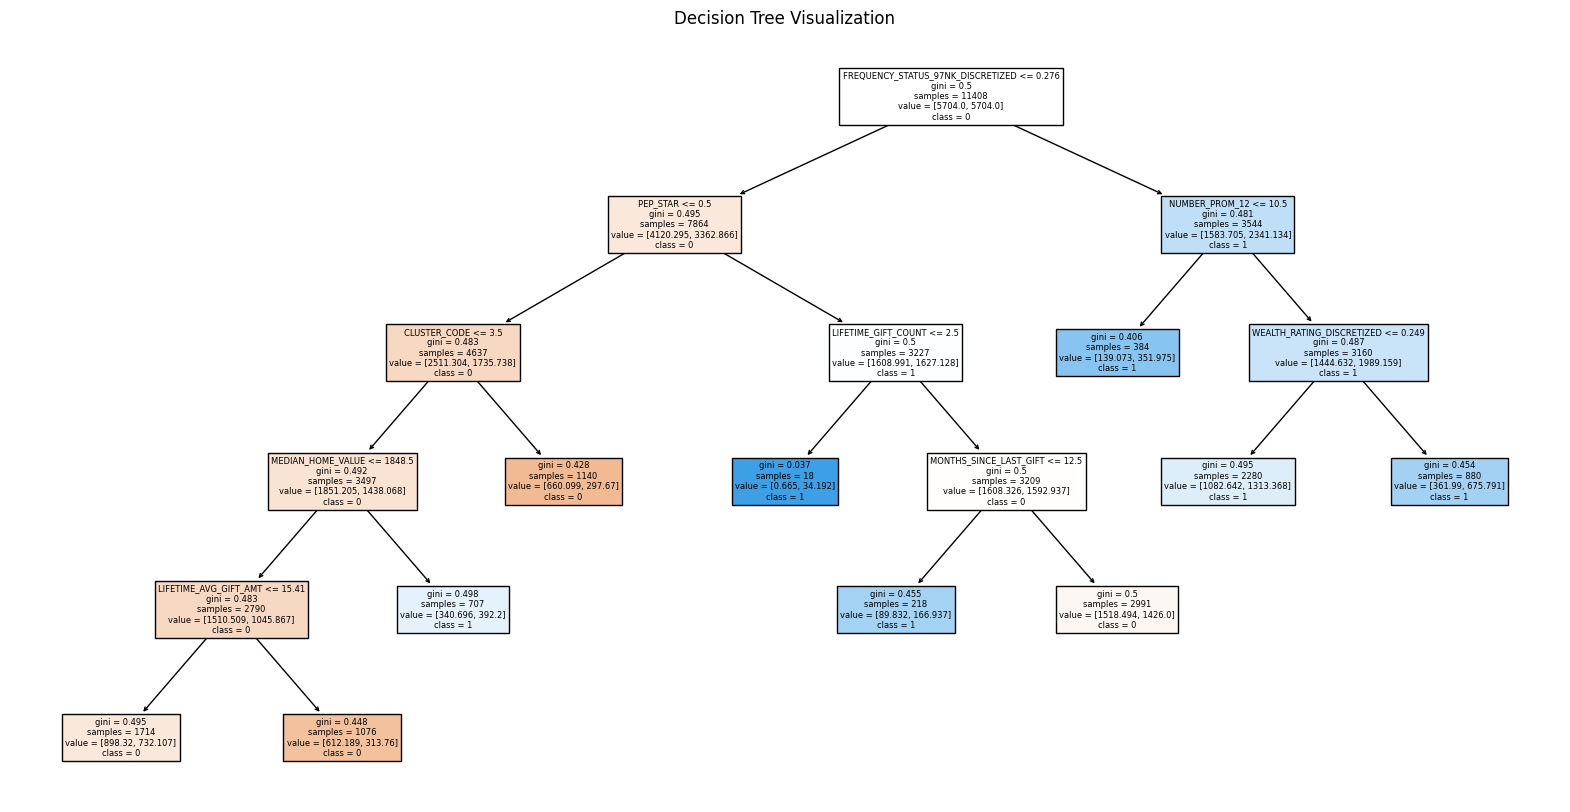

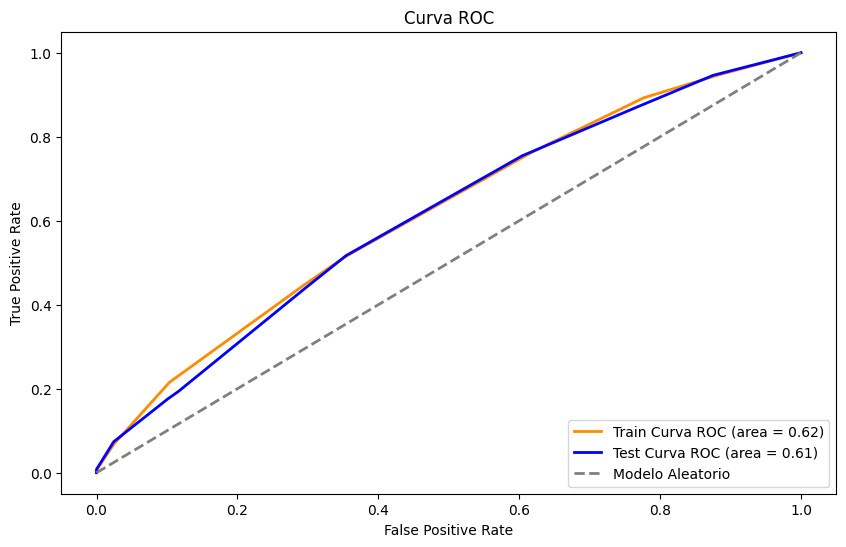

In [ ]:
# Mejores hiperparámetros seleccionados
best_max_depth = best_hyperparameters['max_depth']
print(best_max_depth) #5
best_min_samples_split = best_hyperparameters['min_samples_split']
print(best_min_samples_split) #10
best_ccp_alpha = best_hyperparameters['ccp_alpha']
print(best_ccp_alpha) #0
best_min_impurity_decrease = best_hyperparameters['min_impurity_decrease']
print(best_min_impurity_decrease) #0.01

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    ccp_alpha=0,
    min_impurity_decrease=0.001,
    class_weight='balanced',
    random_state = 2019
)

X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
imputer = KNNImputer(n_neighbors=5)
X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

# Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
X_train['Response_Variable'] = y_train.values
X_test['Response_Variable'] = y_test.values

# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)
X_test = X_test.drop('Response_Variable', axis=1)

# Imputar los valores missing en X_train_fold usando k-NN
X_train_imputed = imputer.fit_transform(X_train)

# Aplicar la imputación al conjunto de validación (X_val_fold)
X_test_imputed = imputer.transform(X_test)

# Ajustar el modelo
best_clf.fit(X_train_imputed, y_train)

# Realizar predicciones en conjuntos de entrenamiento y validación
y_pred_train = best_clf.predict_proba(X_train_imputed)[:, 1]
y_pred_test = best_clf.predict_proba(X_test_imputed)[:, 1]

# Calcular y almacenar las métricas de rendimiento por pliegue
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

#Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
print(f'ROC AUC Train : {roc_auc_train:.4f}')
print(f'ROC AUC Test: {roc_auc_test:.4f}')

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc

# Visualizar el árbol entrenado
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=X_train.columns, class_names=['0', '1'])
plt.title('Decision Tree Visualization')
plt.show()

# Calcular y visualizar las curvas ROC en conjuntos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train Curva ROC (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test Curva ROC (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Modelo Aleatorio')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Usando Preprocess Data 3:

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data3(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

# Definir rangos de hiperparámetros
max_depth_range = [5, 10, 20, 25]
min_samples_split_range = [2, 5, 10, 25, 50]
ccp_alpha_range = [0, 0.01, 0.001,0.0001]
min_impurity_decrease_range = [0.0, 0.01, 0.001,0.0001]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(max_depth_range, min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Decision Tree
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced'
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'max_depth': max_depth_range[best_idx // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}


Evaluando con hiperparámetros: {'max_depth': 5, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.6474
ROC AUC Validation (Mean): 0.5836

Evaluando con hiperparámetros: {'max_depth': 5, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': 5, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.6199
ROC AUC Validation (Mean): 0.5908

Evaluando con hiperparámetros: {'max_depth': 5, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0001}
ROC AUC Train (Mean): 0.6463
ROC AUC Validation (Mean): 0.5841

Evaluando con hiperparámetros: {'max_depth': 5, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': 5, 'min_samples_split': 2, 'ccp_alp

KeyboardInterrupt: 

## Arboles Decision con SubSampling

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

# Definir rangos de hiperparámetros
max_depth_range = [None, 5, 10, 20, 25]
min_samples_split_range = [2, 5, 10, 25, 50]
ccp_alpha_range = [0, 0.01, 0.001,0.0001]
min_impurity_decrease_range = [0.0, 0.01, 0.001,0.0001]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(max_depth_range, min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Decision Tree
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced'
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Subsampling para equilibrar las clases
        X_train_fold_resampled, y_train_fold_resampled = resample(X_train_fold_imputed, y_train_fold,
                                                             n_samples=np.sum(y_train_fold==1),
                                                             random_state=42)

        # Ajustar el modelo
        clf.fit(X_train_fold_resampled, y_train_fold_resampled)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_resampled)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]
        y_pred_val_final=(y_pred_val_fold*np.sum(y_train_fold==1)/0.5)/((y_pred_val_fold*np.sum(y_train_fold==1)/0.5)+((1-y_pred_val_fold)*np.sum(y_train_fold==0)/0.5))


        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold_resampled, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_final)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'max_depth': max_depth_range[best_idx // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}



Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5084

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5658
ROC AUC Validation (Mean): 0.5452

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.9617
ROC AUC Validation (Mean): 0.5108

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0001}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5100

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5658
ROC AUC Validation (Mean): 0.5452

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_s

IndexError: list index out of range

## Arboles decision con preprocesado 2:

In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Definir el número de pliegues para la validación cruzada
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
imputer = KNNImputer(n_neighbors=5)

# Definir rangos de hiperparámetros
max_depth_range = [None, 5, 10, 20, 25]
min_samples_split_range = [2, 5, 10, 20, 40]
ccp_alpha_range = [0, 0.01, 0.001,0.0001]
min_impurity_decrease_range = [0.0, 0.01, 0.001,0.0001]

# Inicializar listas para almacenar las métricas de rendimiento
roc_auc_train_list = []
roc_auc_val_list = []

for (max_depth, min_samples_split, ccp_alpha, min_impurity_decrease) in itertools.product(max_depth_range, min_samples_split_range, ccp_alpha_range, min_impurity_decrease_range):

    # Imprimir los hiperparámetros actuales
    hyperparameters = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha, 'min_impurity_decrease': min_impurity_decrease}
    print(f'\nEvaluando con hiperparámetros: {hyperparameters}')

    # Inicializar y ajustar el modelo Decision Tree
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        ccp_alpha=ccp_alpha,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced'
    )

    # Inicializar listas para almacenar las métricas de rendimiento por pliegue
    roc_auc_train_fold_list = []
    roc_auc_val_fold_list = []

    # Iterar sobre los pliegues de la validación cruzada
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clases_agrupadas = {}
        clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train_fold,y_train_fold,n=5)

        X_train_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train_fold['CLUSTER_CODE']]
        X_val_fold['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_val_fold['CLUSTER_CODE']]

        # Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
        X_train_fold['Response_Variable'] = y_train_fold.values
        X_val_fold['Response_Variable'] = y_val_fold.values

        # Bucle para cada columna categórica en X_train
        for column in X_train_fold.select_dtypes(include='object').columns:
          # Crear un diccionario que asocie cada clase con su media en la variable respuesta
          class_means = X_train_fold.groupby(column)['Response_Variable'].mean().to_dict()

          # Label Encoding con medias de respuesta
          X_train_fold[column] = X_train_fold[column].map(class_means)
          X_val_fold[column] = X_val_fold[column].map(class_means)

        # Eliminar la columna de la variable respuesta después de label encoding
        X_train_fold = X_train_fold.drop('Response_Variable', axis=1)
        X_val_fold = X_val_fold.drop('Response_Variable', axis=1)

        # Imputar los valores missing en X_train_fold usando k-NN
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)

        # Aplicar la imputación al conjunto de validación (X_val_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        # Ajustar el modelo
        clf.fit(X_train_fold_imputed, y_train_fold)

        # Realizar predicciones en conjuntos de entrenamiento y validación
        y_pred_train_fold = clf.predict_proba(X_train_fold_imputed)[:, 1]
        y_pred_val_fold = clf.predict_proba(X_val_fold_imputed)[:, 1]

        # Calcular y almacenar las métricas de rendimiento por pliegue
        roc_auc_train_fold = roc_auc_score(y_train_fold, y_pred_train_fold)
        roc_auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)

        roc_auc_train_fold_list.append(roc_auc_train_fold)
        roc_auc_val_fold_list.append(roc_auc_val_fold)

    # Calcular la media de las métricas de rendimiento por pliegue
    roc_auc_train_mean = np.mean(roc_auc_train_fold_list)
    roc_auc_val_mean = np.mean(roc_auc_val_fold_list)

    # Almacenar las métricas de rendimiento para la combinación actual de hiperparámetros
    roc_auc_train_list.append(roc_auc_train_mean)
    roc_auc_val_list.append(roc_auc_val_mean)

    # Imprimir las métricas de rendimiento para la combinación actual de hiperparámetros
    print(f'ROC AUC Train (Mean): {roc_auc_train_mean:.4f}')
    print(f'ROC AUC Validation (Mean): {roc_auc_val_mean:.4f}')

# Encontrar la mejor combinación de hiperparámetros basada en ROC AUC Validation (Mean)
best_idx = np.argmax(roc_auc_val_list)
best_hyperparameters = {'max_depth': max_depth_range[best_idx // (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'min_samples_split': min_samples_split_range[(best_idx % (len(min_samples_split_range) * len(ccp_alpha_range) * len(min_impurity_decrease_range))) // (len(ccp_alpha_range) * len(min_impurity_decrease_range))],
                        'ccp_alpha': ccp_alpha_range[(best_idx % (len(ccp_alpha_range) * len(min_impurity_decrease_range))) // len(min_impurity_decrease_range)],
                        'min_impurity_decrease': min_impurity_decrease_range[(best_idx % len(min_impurity_decrease_range))]}


Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 1.0000
ROC AUC Validation (Mean): 0.5254

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.01}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.001}
ROC AUC Train (Mean): 0.6212
ROC AUC Validation (Mean): 0.5905

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0, 'min_impurity_decrease': 0.0001}
ROC AUC Train (Mean): 0.9979
ROC AUC Validation (Mean): 0.5148

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.01, 'min_impurity_decrease': 0.0}
ROC AUC Train (Mean): 0.5276
ROC AUC Validation (Mean): 0.5223

Evaluando con hiperparámetros: {'max_depth': None, 'min_samples_s